# Reducing Numerical Errors with Deep Learning

In this example we will target numerical errors that arise in the discretization of a continuous PDE $\mathcal P^*$, i.e. when we formulate $\mathcal P$. This approach will demonstrate that, despite the lack of closed-form descriptions, discretization errors often are functions with regular and repeating structures and, thus, can be learned by a neural network. Once the network is trained, it can be evaluated locally to improve the solution of a PDE-solver, i.e., to reduce its numerical error. The resulting method is a hybrid one: it will always run (a coarse) PDE solver, and then improve it at runtime with corrections inferred by an NN.

 
Pretty much all numerical methods contain some form of iterative process: repeated updates over time for explicit solvers, or within a single update step for implicit solvers. 
An example for the second case could be found [here](https://github.com/tum-pbs/CG-Solver-in-the-Loop),
but below we'll target the first case, i.e. iterations over time.
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/diffphys-code-sol.ipynb)


## Problem formulation

In the context of reducing errors, it's crucial to have a _differentiable physics solver_, so that the learning process can take the reaction of the solver into account. This interaction is not possible with supervised learning or PINN training. Even small inference errors of a supervised NN accumulate over time, and lead to a data distribution that differs from the distribution of the pre-computed data. This distribution shift leads to sub-optimal results, or even cause blow-ups of the solver.

In order to learn the error function, we'll consider two different discretizations of the same PDE $\mathcal P^*$: 
a _reference_ version, which we assume to be accurate, with a discretized version 
$\mathcal P_r$, and solutions $\mathbf r \in \mathscr R$, where $\mathscr R$ denotes the manifold of solutions of $\mathcal P_r$.
In parallel to this, we have a less accurate approximation of the same PDE, which we'll refer to as the _source_ version, as this will be the solver that our NN should later on interact with. Analogously,
we have $\mathcal P_s$ with solutions $\mathbf s \in \mathscr S$.
After training, we'll obtain a _hybrid_ solver that uses $\mathcal P_s$ in conjunction with a trained network to obtain improved solutions, i.e., solutions that are closer to the ones produced by $\mathcal P_r$.

```{figure} resources/diffphys-sol-manifolds.jpeg
---
height: 150px
name: diffphys-sol-manifolds
---
Visual overview of coarse and reference manifolds
```



Let's assume $\mathcal{P}$ advances a solution by a time step $\Delta t$, and let's denote $n$ consecutive steps by a superscript:
$
\newcommand{\pde}{\mathcal{P}}
\newcommand{\pdec}{\pde_{s}}
\newcommand{\vc}[1]{\mathbf{s}_{#1}} 
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\newcommand{\vcN}{\vs}          
\newcommand{\project}{\mathcal{T}}   
\pdec^n ( \mathcal{T} \vr{t} ) = \pdec(\pdec(\cdots \pdec( \mathcal{T} \vr{t}  )\cdots)) .
$ 
The corresponding state of the simulation is
$
\mathbf{s}_{t+n} = \mathcal{P}^n ( \mathcal{T} \mathbf{r}_{t} ) .
$
Here we assume a mapping operator $\mathcal{T}$ exists that transfers a reference solution to the source manifold. This could, e.g., be a simple downsampling operation.
Especially for longer sequences, i.e. larger $n$, the source state 
$\newcommand{\vc}[1]{\mathbf{s}_{#1}} \vc{t+n}$
will deviate from a corresponding reference state
$\newcommand{\vr}[1]{\mathbf{r}_{#1}} \vr{t+n}$. 
This is what we will address with an NN in the following.

As before, we'll use an $L^2$-norm to quantify the deviations, i.e., 
an error function $\newcommand{\loss}{e} 
\newcommand{\corr}{\mathcal{C}} 
\newcommand{\vc}[1]{\mathbf{s}_{#1}} 
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\loss (\vc{t},\mathcal{T} \vr{t})=\Vert\vc{t}-\mathcal{T} \vr{t}\Vert_2$. 
Our learning goal is to train at a correction operator 
$\mathcal{C} ( \mathbf{s} )$ such that 
a solution to which the correction is applied has a lower error than the original unmodified (source) 
solution: $\newcommand{\loss}{e} 
\newcommand{\corr}{\mathcal{C}} 
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\loss ( \mathcal{P}_{s}( \corr (\mathcal{T} \vr{t}) ) , \mathcal{T} \vr{t+1}) < \loss ( \mathcal{P}_{s}( \mathcal{T} \vr{t} ), \mathcal{T} \vr{t+1})$. 

The correction function 
$\newcommand{\vcN}{\mathbf{s}} \newcommand{\corr}{\mathcal{C}} \corr (\vcN | \theta)$ 
is represented as a deep neural network with weights $\theta$
and receives the state $\mathbf{s}$ to infer an additive correction field with the same dimension.
To distinguish the original states $\mathbf{s}$ from the corrected ones, we'll denote the latter with an added tilde $\tilde{\mathbf{s}}$.
The overall learning goal now becomes

$$
\newcommand{\corr}{\mathcal{C}}  
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\text{arg min}_\theta \big( ( \mathcal{P}_{s} \corr )^n ( \mathcal{T} \vr{t} ) - \mathcal{T} \vr{t+n} \big)^2
$$

To simplify the notation, we've dropped the sum over different samples here (the $i$ from previous versions).
A crucial bit that's easy to overlook in the equation above, is that the correction depends on the modified states, i.e.
it is a function of
$\tilde{\mathbf{s}}$, so we have 
$\newcommand{\vctN}{\tilde{\mathbf{s}}} \newcommand{\corr}{\mathcal{C}} \corr (\vctN | \theta)$.
These states actually evolve over time when training. They don't exist beforehand.

**TL;DR**:
We'll train a network $\mathcal{C}$ to reduce the numerical errors of a simulator with a more accurate reference. It's crucial to have the _source_ solver realized as a differential physics operator, such that it provides gradients for an improved training of $\mathcal{C}$.

<br>

---


## Getting started with the implementation

The following replicates an experiment from [Solver-in-the-loop: learning from differentiable physics to interact with iterative pde-solvers](https://ge.in.tum.de/publications/2020-um-solver-in-the-loop/) {cite}`holl2019pdecontrol`, further details can be found in section B.1 of the [appendix](https://arxiv.org/pdf/2007.00016.pdf) of the paper.

First, let's download the prepared data set (for details on generation & loading cf. https://github.com/tum-pbs/Solver-in-the-Loop), and let's get the data handling out of the way, so that we can focus on the _interesting_ parts...

In [15]:
import os, sys, logging, argparse, pickle, glob, random, distutils.dir_util, urllib.request

fname_train = 'sol-karman-2d-train.pickle'
if not os.path.isfile(fname_train):
  print("Downloading training data (73MB), this can take a moment the first time...")
  urllib.request.urlretrieve("https://physicsbaseddeeplearning.org/data/"+fname_train, fname_train)

with open(fname_train, 'rb') as f: data_preloaded = pickle.load(f)
print("Loaded data, {} training sims".format(len(data_preloaded)) )


Loaded data, 6 training sims


Also let's get installing / importing all the necessary libraries out of the way. And while we're at it, we set the random seed - obviously, 42 is the ultimate choice here 🙂

In [16]:
!pip install --upgrade --quiet phiflow==2.1
#!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop

from phi.tf.flow import *
import tensorflow as tf
from tensorflow import keras

random.seed(42) 
np.random.seed(42)
tf.random.set_seed(42)

## Simulation setup

Now we set up the _source_ simulation $\mathcal{P}_{s}$. 
Note that we won't deal with 
$\mathcal{P}_{r}$
below: the downsampled reference data is contained in the training data set. It was generated with a four times finer discretization. Below we're focusing on the interaction of the source solver and the NN. 

This code block and the next ones will define lots of functions, that will be used later on for training.

The `KarmanFlow` solver below simulates a relatively standard wake flow case with a spherical obstacle in a rectangular domain, and an explicit viscosity solve to obtain different Reynolds numbers. This is the geometry of the setup:

```{figure} resources/diffphys-sol-domain.png
---
height: 200px
name: diffphys-sol-domain
---
Domain setup for the wake flow case (sizes in the imlpementation are using an additional factor of 100).
```

The solver applies inflow boundary conditions for the y-velocity with a pre-multiplied mask (`vel_BcMask`), to set the y components at the bottom of the domain during the simulation step. This mask is created with the `HardGeometryMask` from phiflow, which initializes the spatially shifted entries for the components of a staggered grid correctly. The simulation step is quite straight forward: it computes contributions for viscosity, inflow, advection and finally makes the resulting motion divergence free via an implicit pressure solve:

In [17]:
class KarmanFlow():
    def __init__(self, domain):
        self.domain = domain

        self.vel_BcMask = self.domain.staggered_grid(HardGeometryMask(Box[:5, :]) )
    
        self.inflow = self.domain.scalar_grid(Box[5:10, 25:75])         # scale with domain if necessary!
        self.obstacles = [Obstacle(Sphere(center=[50, 50], radius=10))] 

    def step(self, density_in, velocity_in, re, res, buoyancy_factor=0, dt=1.0):
        velocity = velocity_in
        density = density_in

        # viscosity
        velocity = phi.flow.diffuse.explicit(field=velocity, diffusivity=1.0/re*dt*res*res, dt=dt)
        
        # inflow boundary conditions
        velocity = velocity*(1.0 - self.vel_BcMask) + self.vel_BcMask * (1,0)

        # advection 
        density = advect.semi_lagrangian(density+self.inflow, velocity, dt=dt)
        velocity = advected_velocity = advect.semi_lagrangian(velocity, velocity, dt=dt)

        # mass conservation (pressure solve)
        pressure = None
        velocity, pressure = fluid.make_incompressible(velocity, self.obstacles)
        self.solve_info = { 'pressure': pressure, 'advected_velocity': advected_velocity }
        
        return [density, velocity]

    

## Network architecture

We'll also define two alternative versions of a neural networks to represent 
$\newcommand{\vcN}{\mathbf{s}} \newcommand{\corr}{\mathcal{C}} \corr$. In both cases we'll use fully convolutional networks, i.e. networks without any fully-connected layers. We'll use Keras within tensorflow to define the layers of the network (mostly via `Conv2D`), typically activated via ReLU and LeakyReLU functions, respectively.
The inputs to the network are: 
- 2 fields with x,y velocity
- the Reynolds number as constant channel.

The output is: 
- a 2 component field containing the x,y velocity.

First, let's define a small network consisting only of four convolutional layers with ReLU activations (we're also using keras here for simplicity). The input dimensions are determined from input tensor in the `inputs_dict` (it has three channels: u,v, and Re). Then we process the data via three conv layers with 32 features each, before reducing to 2 channels in the output. 

In [18]:
def network_small(inputs_dict):
    l_input = keras.layers.Input(**inputs_dict)
    block_0 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_input)
    block_0 = keras.layers.LeakyReLU()(block_0)

    l_conv1 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_0)
    l_conv1 = keras.layers.LeakyReLU()(l_conv1)
    l_conv2 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv1)
    block_1 = keras.layers.LeakyReLU()(l_conv2)

    l_output = keras.layers.Conv2D(filters=2,  kernel_size=5, padding='same')(block_1) # u, v
    return keras.models.Model(inputs=l_input, outputs=l_output)


For flexibility (and larger-scale tests later on), let's also define a _proper_ ResNet with a few more layers. This architecture is the one from the original paper, and will give a fairly good performance (`network_small` above will train faster, but give a sub-optimal performance at inference time).

In [19]:
def network_medium(inputs_dict):
    l_input = keras.layers.Input(**inputs_dict)
    block_0 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_input)
    block_0 = keras.layers.LeakyReLU()(block_0)

    l_conv1 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_0)
    l_conv1 = keras.layers.LeakyReLU()(l_conv1)
    l_conv2 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv1)
    l_skip1 = keras.layers.add([block_0, l_conv2])
    block_1 = keras.layers.LeakyReLU()(l_skip1)

    l_conv3 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_1)
    l_conv3 = keras.layers.LeakyReLU()(l_conv3)
    l_conv4 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv3)
    l_skip2 = keras.layers.add([block_1, l_conv4])
    block_2 = keras.layers.LeakyReLU()(l_skip2)

    l_conv5 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_2)
    l_conv5 = keras.layers.LeakyReLU()(l_conv5)
    l_conv6 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv5)
    l_skip3 = keras.layers.add([block_2, l_conv6])
    block_3 = keras.layers.LeakyReLU()(l_skip3)

    l_conv7 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_3)
    l_conv7 = keras.layers.LeakyReLU()(l_conv7)
    l_conv8 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv7)
    l_skip4 = keras.layers.add([block_3, l_conv8])
    block_4 = keras.layers.LeakyReLU()(l_skip4)

    l_conv9 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_4)
    l_conv9 = keras.layers.LeakyReLU()(l_conv9)
    l_convA = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv9)
    l_skip5 = keras.layers.add([block_4, l_convA])
    block_5 = keras.layers.LeakyReLU()(l_skip5)

    l_output = keras.layers.Conv2D(filters=2,  kernel_size=5, padding='same')(block_5)
    return keras.models.Model(inputs=l_input, outputs=l_output)


Next, we're coming to two functions which are pretty important: they transform the simulation state into an input tensor for the network, and vice versa. Hence, they're the interface between _keras/tensorflow_ and _phiflow_.

The `to_keras` function uses the two vector components via `vector['x']` and `vector['y']` to discard the outermost layer of the velocity field grids. This gives two tensors of equal size that are concatenated. 
It then adds a constant channel via `math.ones` that is multiplied by the desired Reynolds number in `ext_const_channel`. The resulting stack of grids is stacked along the `channels` dimensions, and represents an  input to the neural network. 

After network evaluation, we transform the output tensor back into a phiflow grid via the `to_phiflow` function. 
It converts the 2-component tensor that is returned by the network into a phiflow staggered grid object, so that it is compatible with the velocity field of the fluid simulation.
(Note: these are two _centered_ grids with different sizes, so we leave the work to the `domain.staggered_grid` function, which also sets physical size and boundary conditions as given by the domain object).

In [20]:

def to_keras(dens_vel_grid_array, ext_const_channel):
    # align the sides the staggered velocity grid making its size the same as the centered grid
    return math.stack(
        [
            math.pad( dens_vel_grid_array[1].vector['x'].values, {'x':(0,1)} , math.extrapolation.ZERO),
            dens_vel_grid_array[1].vector['y'].y[:-1].values,         # v
            math.ones(dens_vel_grid_array[0].shape)*ext_const_channel # Re
        ],
        math.channel('channels')
    )

def to_phiflow(tf_tensor, domain):
    return domain.staggered_grid(
        math.stack(
            [
                math.tensor(tf.pad(tf_tensor[..., 1], [(0,0), (0,1), (0,0)]), math.batch('batch'), math.spatial('y, x')), # v
                math.tensor( tf_tensor[...,:-1, 0], math.batch('batch'), math.spatial('y, x')), # u 
            ], math.channel('vector')
        )
    )


---

## Data handling

So far so good - we also need to take care of a few more mundane tasks, e.g., some data handling and randomization. Below we define a `Dataset` class that stores all "ground truth" reference data (already downsampled).

We actually have a lot of data dimensions: multiple simulations, with many time steps, each with different fields. This makes the code below a bit more difficult to read.

The data format for the numpy array `dataPreloaded`: is  `['sim_name', frame, field (dens & vel)]`, where each field has dimension `[batch-size, y-size, x-size, channels]` (this is the standard for a phiflow export).

In [21]:
class Dataset():
    def __init__(self, data_preloaded, num_frames, num_sims=None, batch_size=1, is_testset=False):
        self.epoch         = None
        self.epochIdx      = 0
        self.batch         = None
        self.batchIdx      = 0
        self.step          = None
        self.stepIdx       = 0

        self.dataPreloaded = data_preloaded
        self.batchSize     = batch_size

        self.numSims       = num_sims
        self.numBatches    = num_sims//batch_size
        self.numFrames     = num_frames
        self.numSteps      = num_frames
        
        # initialize directory keys (using naming scheme from SoL codebase)
        # constant additional per-sim channel: Reynolds numbers from data generation
        # hard coded for training and test data here
        if not is_testset:
            self.dataSims = ['karman-fdt-hires-set/sim_%06d'%i for i in range(num_sims) ]
            ReNrs = [160000.0, 320000.0, 640000.0,  1280000.0,  2560000.0,  5120000.0]
            self.extConstChannelPerSim = { self.dataSims[i]:[ReNrs[i]] for i in range(num_sims) }
        else:
            self.dataSims = ['karman-fdt-hires-testset/sim_%06d'%i for i in range(num_sims) ]
            ReNrs = [120000.0, 480000.0, 1920000.0, 7680000.0] 
            self.extConstChannelPerSim = { self.dataSims[i]:[ReNrs[i]] for i in range(num_sims) }

        self.dataFrames = [ np.arange(num_frames) for _ in self.dataSims ]  

        # debugging example, check shape of a single marker density field:
        #print(format(self.dataPreloaded[self.dataSims[0]][0][0].shape )) 
        
        # the data has the following shape ['sim', frame, field (dens/vel)] where each field is [batch-size, y-size, x-size, channels]
        self.resolution = self.dataPreloaded[self.dataSims[0]][0][0].shape[1:3]  

        # compute data statistics for normalization
        self.dataStats = {
            'std': (
                np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][0].reshape(-1)) for asim in self.dataSims for i in range(num_frames)], axis=-1)), # density
                np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][1].reshape(-1)) for asim in self.dataSims for i in range(num_frames)], axis=-1)), # x-velocity
                np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][2].reshape(-1)) for asim in self.dataSims for i in range(num_frames)], axis=-1)), # y-velocity
            )
        }
        self.dataStats.update({
            'ext.std': [ np.std([np.absolute(self.extConstChannelPerSim[asim][0]) for asim in self.dataSims]) ] # Reynolds Nr
        })

        
        if not is_testset:
            print("Data stats: "+format(self.dataStats))


    # re-shuffle data for next epoch
    def newEpoch(self, exclude_tail=0, shuffle_data=True):
        self.numSteps = self.numFrames - exclude_tail
        simSteps = [ (asim, self.dataFrames[i][0:(len(self.dataFrames[i])-exclude_tail)]) for i,asim in enumerate(self.dataSims) ]
        sim_step_pair = []
        for i,_ in enumerate(simSteps):
            sim_step_pair += [ (i, astep) for astep in simSteps[i][1] ]  # (sim_idx, step) ...

        if shuffle_data: random.shuffle(sim_step_pair)
        self.epoch = [ list(sim_step_pair[i*self.numSteps:(i+1)*self.numSteps]) for i in range(self.batchSize*self.numBatches) ]
        self.epochIdx += 1
        self.batchIdx = 0
        self.stepIdx = 0

    def nextBatch(self):  
        self.batchIdx += self.batchSize
        self.stepIdx = 0

    def nextStep(self):
        self.stepIdx += 1


The `nextEpoch`, `nextBatch`, and `nextStep` functions will be called at training time to randomize the order of the training data.

Now we need one more function that compiles the data for a mini batch to train with, called `getData` below. It returns batches of the desired size in terms of marker density, velocity, and Reynolds number.


In [22]:
# for class Dataset():
def getData(self, consecutive_frames):
    d_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][0]
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]
    u_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][1]
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]
    v_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][2]
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]
    ext = [
        self.extConstChannelPerSim[
            self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]]
        ][0] for i in range(self.batchSize)
    ]
    return [d_hi, u_hi, v_hi, ext]


Note that the `density` here denotes a passively advected marker field, and not the density of the fluid. Below we'll be focusing on the velocity only, the marker density is tracked purely for visualization purposes.

After all the definitions we can finally run some code. We define the dataset object with the downloaded data from the first cell.

In [23]:
nsims = 6
batch_size = 3
simsteps = 500

dataset = Dataset( data_preloaded=data_preloaded, num_frames=simsteps, num_sims=nsims, batch_size=batch_size )

Data stats: {'std': (2.6542656, 0.23155601, 0.3066732), 'ext.std': [1732512.6262166172]}


Additionally, we've defined several global variables to control the training and the simulation in the next code cells.

The most important and interesting one is `msteps`. It defines the number of simulation steps that are unrolled at each training iteration. This directly influences the runtime of each training step, as we first have to simulate all steps forward, and then backpropagate the gradient through all `msteps` simulation steps interleaved with the NN evaluations. However, this is where we'll receive important feedback in terms of gradients how the inferred corrections actually influence a running simulation. Hence, larger `msteps` are typically better.

In addition we define the resolution of the simulation in `source_res`, and allocate the fluid solver object called `simulator`. In order to create grids, it requires access to a `Domain` object, which mostly exists for convenience purposes: it stores resolution, physical size in `bounds`, and boundary conditions of the domain. This information needs to be passed to every grid, and hence it's convenient to have it in one place in the form of the `Domain`. For the setup described above, we need different boundary conditions along x and y: closed walls, and free flow in and out of the domain, respecitvely.

We also instantiate the actual NN `network` in the next cell. 

In [24]:
# one of the most crucial! how many simulation steps to look into the future while training
msteps = 4

# # this is the actual resolution in terms of cells
source_res = list(dataset.resolution)
# # this is a virtual size, in terms of abstract units for the bounding box of the domain (it's important for conversions or when rescaling to physical units)
simulation_length = 100.

# for readability
from phi.physics._boundaries import Domain, OPEN, STICKY as CLOSED

boundary_conditions = {
    'x':(phi.physics._boundaries.STICKY,phi.physics._boundaries.STICKY), 
    'y':(phi.physics._boundaries.OPEN,  phi.physics._boundaries.OPEN) }

domain = Domain(y=source_res[0], x=source_res[1], bounds=Box[0:2*simulation_length, 0:simulation_length], boundaries=boundary_conditions)
simulator = KarmanFlow(domain=domain)

network = network_small(dict(shape=(source_res[0],source_res[1], 3)))
network.summary()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Domain is deprecated and will be removed in a future release. Use a dict instead, e.g. CenteredGrid(values, extrapolation, **domain_dict)
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Domain is deprecated and will be removed in a future release. Use a dict instead, e.g. CenteredGrid(values, extrapolation, **domain_dict)
  app.launch_new_instance()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 32, 32)        2432      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 32, 32)        25632     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 32, 32)        25632     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 32, 32)        0   

## Interleaving simulation and NN

Now comes the **most crucial** step in the whole setup: we define a function that encapsulates the chain of simulation steps and network evaluations in each training step. After all the work defining helper functions, it's actually pretty simple: we create a gradient tape via `tf.GradientTape()` such that we can backpropagate later on. We then loop over `msteps`, call the simulator via `simulator.step` for an input state, and afterwards evaluate the correction via `network(to_keras(...))`. The NN correction is then added to the last simulation state in the `prediction` list (we're actually simply overwriting the last simulated velocity `prediction[-1][1]` with `prediction[-1][1] + correction[-1]`.

One other important thing that's happening here is normalization: the inputs to the network are divided by the standard deviations in `dataset.dataStats`. After evaluating the `network`, we only have a velocity left, so we simply multiply it by the standard deviation of the velocity again (via `* dataset.dataStats['std'][1]` and `[2]`).

The `training_step` function also directly evaluates and returns the loss. Here, we simply use an $L^2$ loss over the whole sequence, i.e. the iteration over `msteps`. This is requiring a few lines of code because we separately loop over 'x' and 'y' components, in order to normalize and compare to the ground truth values from the training data set.

The "learning" happens in the last two lines via `tape.gradient()` and `opt.apply_gradients()`, which then contain the aggregated information about how to change the NN weights to nudge the simulation closer to the reference for the full chain of simulation steps.

In [25]:
def training_step(dens_gt, vel_gt, Re, i_step):
    with tf.GradientTape() as tape:
        prediction, correction = [ [dens_gt[0],vel_gt[0]] ], [0] # predicted states with correction, inferred velocity corrections

        for i in range(msteps):
            prediction += [
                simulator.step(
                    density_in=prediction[-1][0],
                    velocity_in=prediction[-1][1],
                    re=Re, res=source_res[1],
                )
            ]       # prediction: [[density1, velocity1], [density2, velocity2], ...]

            model_input = to_keras(prediction[-1], Re)
            model_input /= math.tensor([dataset.dataStats['std'][1], dataset.dataStats['std'][2], dataset.dataStats['ext.std'][0]], channel('channels')) # [u, v, Re]
            model_out = network(model_input.native(['batch', 'y', 'x', 'channels']), training=True)
            model_out *= [dataset.dataStats['std'][1], dataset.dataStats['std'][2]] # [u, v]
            correction += [ to_phiflow(model_out, domain) ]                         # [velocity_correction1, velocity_correction2, ...]

            prediction[-1][1] = prediction[-1][1] + correction[-1]
            #prediction[-1][1] = correction[-1]

        # evaluate loss
        loss_steps_x = [
            tf.nn.l2_loss(
                (
                    vel_gt[i].vector['x'].values.native(('batch', 'y', 'x'))
                    - prediction[i][1].vector['x'].values.native(('batch', 'y', 'x'))
                )/dataset.dataStats['std'][1]
            )
            for i in range(1,msteps+1)
        ]
        loss_steps_x_sum = tf.math.reduce_sum(loss_steps_x)

        loss_steps_y = [
            tf.nn.l2_loss(
                (
                    vel_gt[i].vector['y'].values.native(('batch', 'y', 'x'))
                    - prediction[i][1].vector['y'].values.native(('batch', 'y', 'x'))
                )/dataset.dataStats['std'][2]
            )
            for i in range(1,msteps+1)
        ]
        loss_steps_y_sum = tf.math.reduce_sum(loss_steps_y)

        loss = (loss_steps_x_sum + loss_steps_y_sum)/msteps

        gradients = tape.gradient(loss, network.trainable_variables)
        opt.apply_gradients(zip(gradients, network.trainable_variables))

        return math.tensor(loss)    


Once defined, we prepare this function for executing the training step by calling phiflow's `math.jit_compile()` function. It automatically maps to the correct pre-compilation step of the chosen backend. E.g., for TF this internally creates a computational graph, and optimizes the chain of operations. For JAX, it can even compile optimized GPU code (if JAX is set up correctly). Thus, using the jit compilation can make a huge difference in terms of runtime.

In [26]:

training_step_jit = math.jit_compile(training_step)


## Training

For the training, we use a standard Adam optimizer, and run 15 epochs by default. This should be increased for the larger network or to obtain more accurate results. For longer training runs, it would also be beneficial to decrease the learning rate over the course of the epochs, but for simplicity, we'll keep `LR` constant here.

Optionally, this is also the right point to load a network state to resume training.

In [27]:
LR = 1e-4
EPOCHS = 15

opt = tf.keras.optimizers.Adam(learning_rate=LR) 

# optional, load existing network...
# set to epoch nr. to load existing network from there
resume = 0
if resume>0: 
    ld_network = keras.models.load_model('./nn_epoch{:04d}.h5'.format(resume)) 
    #ld_network = keras.models.load_model('./nn_final.h5') # or the last one
    network.set_weights(ld_network.get_weights())
    

Finally, we can start training the NN! This is very straight forward now, we simply loop over the desired number of iterations, get a batch each time via `getData`, feed it into the source simulation input `source_in`, and compare it in the loss with the `reference` data for the batch.

The setup above will automatically take care that the differentiable physics solver used here provides the right gradient information, and provides it to the tensorflow network. Be warned: due to the complexity of the setup, this training run can take a while... (If you have a saved `nn_final.h5` network from a previous run, you can potentially skip this block and load the previously trained model instead via the cell above.)

In [28]:
steps = 0
for j in range(EPOCHS):  # training
    dataset.newEpoch(exclude_tail=msteps)
    if j<resume:
        print('resume: skipping {} epoch'.format(j+1))
        steps += dataset.numSteps*dataset.numBatches
        continue

    for ib in range(dataset.numBatches):   
        for i in range(dataset.numSteps): 

            # batch: [[dens0, dens1, ...], [x-velo0, x-velo1, ...], [y-velo0, y-velo1, ...], [ReynoldsNr(s)]]            
            batch = getData(dataset, consecutive_frames=msteps)
            
            dens_gt = [   # [density0:CenteredGrid, density1, ...]
                domain.scalar_grid(
                    math.tensor(batch[0][k], math.batch('batch'), math.spatial('y, x'))
                ) for k in range(msteps+1)
            ]

            vel_gt = [   # [velocity0:StaggeredGrid, velocity1, ...]
                domain.staggered_grid(
                    math.stack(
                        [
                            math.tensor(batch[2][k], math.batch('batch'), math.spatial('y, x')),
                            math.tensor(batch[1][k], math.batch('batch'), math.spatial('y, x')),
                        ], math.channel('vector')
                    )
                ) for k in range(msteps+1)
            ]
            re_nr = math.tensor(batch[3], math.batch('batch'))

            loss = training_step_jit(dens_gt, vel_gt, re_nr, math.tensor(steps)) 
            
            steps += 1
            if (j==0 and ib==0 and i<3) or (j==0 and ib==0 and i%128==0) or (j>0 and ib==0 and i==400): # reduce output 
              print('epoch {:03d}/{:03d}, batch {:03d}/{:03d}, step {:04d}/{:04d}: loss={}'.format( j+1, EPOCHS, ib+1, dataset.numBatches, i+1, dataset.numSteps, loss ))
            
            dataset.nextStep()

        dataset.nextBatch()

    if j%10==9: network.save('./nn_epoch{:04d}.h5'.format(j+1))

# all done! save final version
network.save('./nn_final.h5'); print("Training done, saved NN")


epoch 001/015, batch 001/002, step 0001/0496: loss=2607.0625
epoch 001/015, batch 001/002, step 0002/0496: loss=1486.0303955078125
epoch 001/015, batch 001/002, step 0003/0496: loss=791.0106201171875
epoch 001/015, batch 001/002, step 0129/0496: loss=98.65435028076172
epoch 001/015, batch 001/002, step 0257/0496: loss=75.35194396972656
epoch 001/015, batch 001/002, step 0385/0496: loss=70.05856323242188
epoch 002/015, batch 001/002, step 0401/0496: loss=19.132190704345703
epoch 003/015, batch 001/002, step 0401/0496: loss=9.645946502685547
epoch 004/015, batch 001/002, step 0401/0496: loss=7.916687965393066
epoch 005/015, batch 001/002, step 0401/0496: loss=3.710268497467041
epoch 006/015, batch 001/002, step 0401/0496: loss=3.1778054237365723
epoch 007/015, batch 001/002, step 0401/0496: loss=2.8747799396514893
epoch 008/015, batch 001/002, step 0401/0496: loss=3.5371036529541016
epoch 009/015, batch 001/002, step 0401/0496: loss=1.6915209293365479
epoch 010/015, batch 001/002, step 0

The loss should go down from above 1000 initially to below 10. This is a good sign, but of course it's even more important to see how the NN-solver combination fares on new inputs. With this training approach we've realized a hybrid solver, consisting of a regular _source_ simulator, and a network that was trained to specifically interact with this simulator for a chosen domain of simulation cases.

Let's see how well this works by applying it to a set of test data inputs with new Reynolds numbers that were not part of the training data.

To keep things somewhat simple, we won't aim for a high-performance version of our hybrid solver. For performance, please check out the external code base: the network trained here should be directly useable in [this apply script](https://github.com/tum-pbs/Solver-in-the-Loop/blob/master/karman-2d/karman_apply.py).

---

## Evaluation 

In order to evaluate the performance of our DL-powered solver, we essentially only need to repeat the inner loop of each training iteration for more steps. While we were limited to `msteps` evaluations at training time, we can now run our solver for arbitrary lengths. This is a good test for how well our solver has learned to keep the data within the desired distribution, and represents a generalization test for longer rollouts.

We reuse the solver code from above, but in the following, we will consider two simulated versions: for comparison, we'll run one reference simulation in the _source_ space (i.e., without any modifications). This version receives the regular outputs of each evaluation of the simulator, and ignores the learned correction (stored in `steps_source` below). The second version, repeatedly computes the source solver plus the learned correction, and advances this state in the solver (`steps_hybrid`).

We also need a set of new data. Below, we'll download a new set of Reynolds numbers (in between the ones used for training), on which we will later on run the unmodified simulator and the DL-powered one.


In [29]:
fname_test = 'sol-karman-2d-test.pickle'
if not os.path.isfile(fname_test):
  print("Downloading test data (38MB), this can take a moment the first time...")
  urllib.request.urlretrieve("https://physicsbaseddeeplearning.org/data/"+fname_test, fname_test)

with open(fname_test, 'rb') as f: data_test_preloaded = pickle.load(f)
print("Loaded test data, {} training sims".format(len(data_test_preloaded)) )

Loaded test data, 4 training sims


Next we create a new dataset object `dataset_test` that organizes the data. We're simply using the first batch of the unshuffled dataset, though.

A subtle but important point: we still have to use the normalization from the original training data set: `dataset.dataStats['std']` values. The test data set has it's own mean and standard deviation, and so the trained NN never saw this data before. The NN was trained with the data in `dataset` above, and hence we have to use the constants from there for normalization to make sure the network receives values that it can relate to the data it was trained with.

In [30]:
dataset_test = Dataset( data_preloaded=data_test_preloaded, is_testset=True, num_frames=simsteps, num_sims=4, batch_size=4 )

# we only need 1 batch with t=0 states to initialize the test simulations with
dataset_test.newEpoch(shuffle_data=False)
batch = getData(dataset_test, consecutive_frames=0) 

re_nr_test = math.tensor(batch[3], math.batch('batch')) # Reynolds numbers
print("Reynolds numbers in test data set: "+format(re_nr_test))

Reynolds numbers in test data set: (120000.0, 480000.0, 1920000.0, 7680000.0) along batchᵇ


Next we construct a `math.tensor` as initial state for the centered marker fields, and a staggered grid from the next two indices of the test set batch. Similar to `to_phiflow` above, we use `phi.math.stack()` to combine two fields of appropriate size as a staggered grid.

In [31]:
source_dens_initial = math.tensor( batch[0][0], math.batch('batch'), math.spatial('y, x'))

source_vel_initial = domain.staggered_grid(phi.math.stack([
    math.tensor(batch[2][0], math.batch('batch'),math.spatial('y, x')),
    math.tensor(batch[1][0], math.batch('batch'),math.spatial('y, x'))], channel('vector')))


Now we first run the _source_ simulation for 120 steps as baseline:

In [32]:
source_dens_test, source_vel_test = source_dens_initial, source_vel_initial
steps_source = [[source_dens_test,source_vel_test]]

# note - math.jit_compile() not useful for numpy solve... hence not necessary
for i in range(120):
    [source_dens_test,source_vel_test] = simulator.step(
        density_in=source_dens_test,
        velocity_in=source_vel_test,
        re=re_nr_test,
        res=source_res[1],
    )
    steps_source.append( [source_dens_test,source_vel_test] )

print("Source simulation steps "+format(len(steps_source)))

Source simulation steps 121


Next, we compute the corresponding states of our learned hybrid solver. Here, we closely follow the training code, however, now without any gradient tapes or loss computations. We only evaluate the NN in a forward pass for each simulated state to compute a correction field:


In [33]:
source_dens_test, source_vel_test = source_dens_initial, source_vel_initial
steps_hybrid = [[source_dens_test,source_vel_test]]
        
for i in range(120):
    [source_dens_test,source_vel_test] = simulator.step(
        density_in=source_dens_test,
        velocity_in=source_vel_test,
        re=math.tensor(re_nr_test),
        res=source_res[1],
    )
    model_input = to_keras([source_dens_test,source_vel_test], re_nr_test )
    model_input /= math.tensor([dataset.dataStats['std'][1], dataset.dataStats['std'][2], dataset.dataStats['ext.std'][0]], channel('channels')) # [u, v, Re]
    model_out = network(model_input.native(['batch', 'y', 'x', 'channels']), training=False)
    model_out *= [dataset.dataStats['std'][1], dataset.dataStats['std'][2]] # [u, v]
    correction =  to_phiflow(model_out, domain) 
    source_vel_test = source_vel_test+correction

    steps_hybrid.append( [source_dens_test, source_vel_test] )
    
print("Steps with hybrid solver "+format(len(steps_hybrid)))

Steps with hybrid solver 121


Given the stored states, we quantify the improvements that the NN yields, and visualize the results. 

In the following cells, the index `b` chooses one of the four test simulations (by default index 0, the lowest Re outside the training data range), and computes the accumulated mean absolute error (MAE) over all time steps.


MAE for source: 0.13729144632816315 , and hybrid: 0.045980848371982574


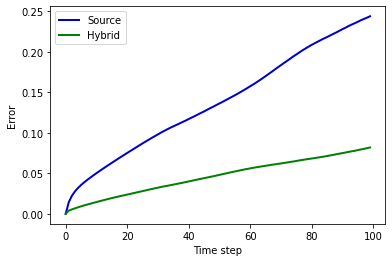

In [34]:
import pylab
b = 0 # batch index for the following comparisons

errors_source, errors_pred = [], []
for index in range(100):
  vx_ref = dataset_test.dataPreloaded[ dataset_test.dataSims[b] ][ index ][1][0,...]
  vy_ref = dataset_test.dataPreloaded[ dataset_test.dataSims[b] ][ index ][2][0,...]
  vxs = vx_ref - steps_source[index][1].values.vector[1].numpy('batch,y,x')[b,...]
  vxh = vx_ref - steps_hybrid[index][1].values.vector[1].numpy('batch,y,x')[b,...]
  vys = vy_ref - steps_source[index][1].values.vector[0].numpy('batch,y,x')[b,...] 
  vyh = vy_ref - steps_hybrid[index][1].values.vector[0].numpy('batch,y,x')[b,...] 
  errors_source.append(np.mean(np.abs(vxs)) + np.mean(np.abs(vys))) 
  errors_pred.append(np.mean(np.abs(vxh)) + np.mean(np.abs(vyh)))

fig = pylab.figure().gca()
pltx = np.linspace(0,99,100)
fig.plot(pltx, errors_source, lw=2, color='mediumblue', label='Source')  
fig.plot(pltx, errors_pred,   lw=2, color='green', label='Hybrid')
pylab.xlabel('Time step'); pylab.ylabel('Error'); fig.legend()

print("MAE for source: "+format(np.mean(errors_source)) +" , and hybrid: "+format(np.mean(errors_pred)) )

Due to the complexity of the training, the performance varies but typically the overall MAE is ca. 160% larger for the regular simulation compared to the hybrid simulator. 
The gap is typically even bigger for other Reynolds numbers within the training data range. 
The graph above also shows this behavior over time.

Let's also visualize the differences of the two outputs by plotting the y component of the velocities over time. The two following code cells show six velocity snapshots for the batch index `b` in intervals of 20 time steps.

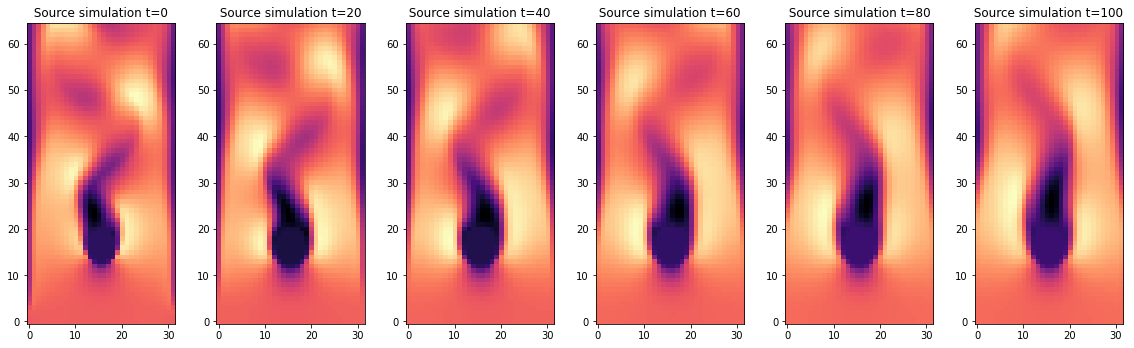

In [35]:
c = 0          # channel selector, x=1 or y=0 
interval = 20  # time interval

fig, axes = pylab.subplots(1, 6, figsize=(16, 5))    
for i in range(0,6):
  v = steps_source[i*interval][1].values.vector[c].numpy('batch,y,x')[b,...]
  axes[i].imshow( v , origin='lower', cmap='magma')
  axes[i].set_title(f" Source simulation t={i*interval} ")

pylab.tight_layout()

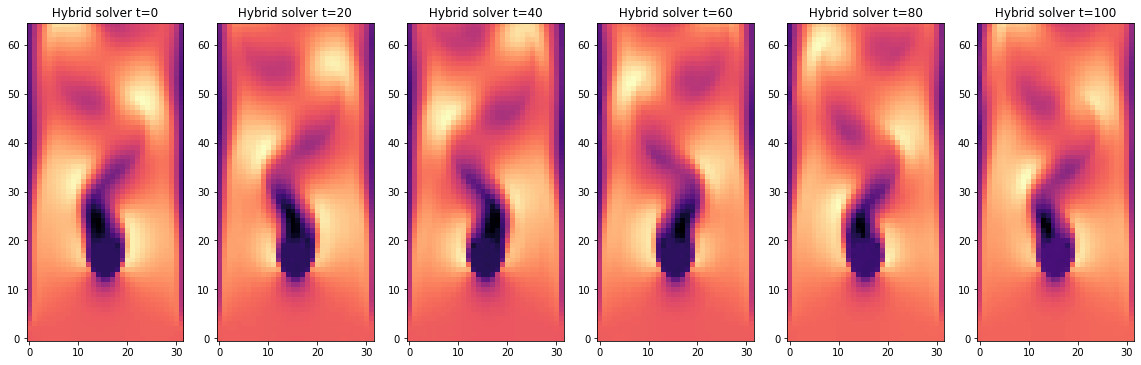

In [36]:
fig, axes = pylab.subplots(1, 6, figsize=(16, 5))
for i in range(0,6):
  v = steps_hybrid[i*interval][1].values.vector[c].numpy('batch,y,x')[b,...]
  axes[i].imshow( v , origin='lower', cmap='magma')
  axes[i].set_title(f" Hybrid solver t={i*interval} ")
pylab.tight_layout()

They both start out with the same initial state at $t=0$ (the downsampled solution from the reference solution manifold), and at $t=20$ the solutions still share similarities. Over time, the source version strongly diffuses the structures in the flow and looses momentum. The flow behind the obstacles becomes straight, and lacks clear vortices. 

The version produced by the hybrid solver does much better. It preserves the vortex shedding even after more than one hundred updates. Note that both outputs were produced by the same underlying solver. The second version just profits from the learned corrector which manages to revert the numerical errors of the source solver, including its overly strong dissipation. 

We also visually compare how the NN does w.r.t. reference data. The next cell plots one time step of the three versions: the reference data after 50 steps, and the re-simulated version of the source and our hybrid solver, together with a per-cell error of the two:

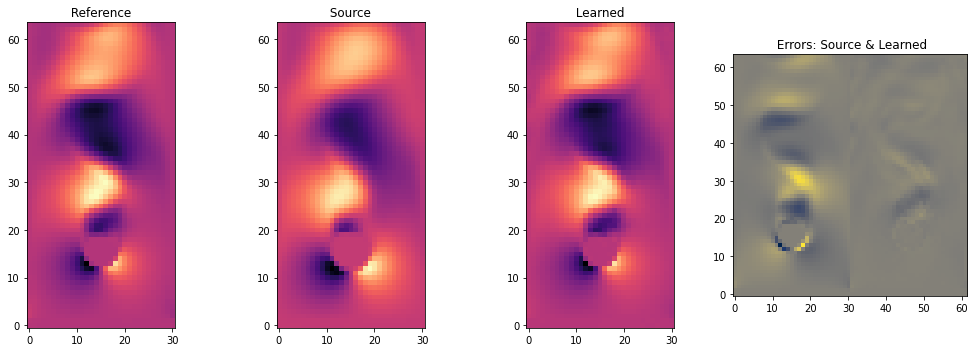

In [37]:
index = 50 # time step index
vx_ref = dataset_test.dataPreloaded[ dataset_test.dataSims[b] ][ index ][1][0,...]
vx_src = steps_source[index][1].values.vector[1].numpy('batch,y,x')[b,...]
vx_hyb = steps_hybrid[index][1].values.vector[1].numpy('batch,y,x')[b,...]

fig, axes = pylab.subplots(1, 4, figsize=(14, 5))

axes[0].imshow( vx_ref , origin='lower', cmap='magma')
axes[0].set_title(f" Reference ")

axes[1].imshow( vx_src , origin='lower', cmap='magma')
axes[1].set_title(f" Source ")

axes[2].imshow( vx_hyb , origin='lower', cmap='magma')
axes[2].set_title(f" Learned ")

# show error side by side
err_source = vx_ref - vx_src 
err_hybrid = vx_ref - vx_hyb 
v = np.concatenate([err_source,err_hybrid], axis=1)
axes[3].imshow( v , origin='lower', cmap='cividis')
axes[3].set_title(f" Errors: Source & Learned")

pylab.tight_layout()


This shows very clearly how the pure source simulation in the middle deviates from the reference on the left. The learned version stays much closer to the reference solution. 

The two per-cell error images on the right also illustrate this: the source version has much larger errors (i.e. brighter colors) that show how it systematically underestimates the vortices that should form. The error for the learned version is much more evenly distributed and significantly smaller in magnitude.


This concludes our evaluation. Note that the improved behavior of the hybrid solver can be difficult to reliably measure with simple vector norms such as an MAE or $L^2$ norm. To improve this, we'd need to employ other, domain-specific metrics. In this case, metrics for fluids based on vorticity and turbulence properties of the flow would be applicable. However, in this text, we instead want to focus on DL-related topics and target another inverse problem with differentiable physics solvers in the next chapter.

## Next steps

* Modify the training to further reduce the training error. With the _medium_ network you should be able to get the loss down to around 1.

* Turn off the differentiable physics training (by setting `msteps=1`), and compare it with the DP version.

* Likewise, train a network with a larger `msteps` setting, e.g., 8 or 16. Note that due to the recurrent nature of the training, you'll probably have to load a pre-trained state to stabilize the first iterations.

* Use the external github code to generate new test data, and run your trained NN on these cases. You'll see that a reduced training error not always directly correlates with an improved test performance.

